Epidemiological data suggests an association between increased HDL-c and a protection from coronary artery disease (CAD). Data from clinical trials of HDL-c increasing drugs shows that this association is likely not causal, but some HDL-c increasing genetic variants to protect against CAD.

Here, we showcase the _exphewas_ API to estimate the MR effect of all HDL-c associated genes on CAD. Note that this is an exploratory analysis. A more thoughtful investigation of the MR assumptions should be done to interpret the presented effects as true causal effects.

In [3]:
import gzip
import pickle

import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from adjustText import adjust_text

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [5]:
# Genes significantly associated with HDL-c.
req = requests.get("https://exphewas.ca/v1/api/outcome/cont_v70/results")

In [6]:
hdl_assoc = req.json()

In [7]:
# Keep genes with a FDR of 0.001%
hdl_assoc_sig = [o for o in hdl_assoc if o["q"] <= 0.00001]

In [17]:
# MR effects (load from cache or query from website)
try:
    with gzip.open("hdl_cad_cis_MR_results.pkl.gz", "rb") as f:
        mr_results = pickle.load(f)
except FileNotFoundError:
    mr_results = []
    for i, o in enumerate(hdl_assoc_sig):
        url = (
            "https://exphewas.ca/v1/api/cisMR?"
            "exposure_id=cont_v70&"
            "exposure_type=CONTINUOUS_VARIABLE&"
            "outcome_id=411.4&"
            "outcome_type=PHECODES&"
            "ensembl_id={gene}"
        )
        req = requests.get(url.format(gene=o["gene"]))
        res = req.json()
        res["gene"] = o["gene"]
        mr_results.append(res)
        
    # Serialize because it takes a while to get the results
    with gzip.open("hdl_cad_cis_MR_results.pkl.gz", "wb") as f:
        pickle.dump(mr_results, f)

In [18]:
# Instrument strength will be the inverse variance weighted effect on the exposure.
def iv_strength(summary_stats):
    # Filter out not associated (eq of p<0.05)
    summary_stats = [
        o for o in summary_stats
        if np.abs(o["exposure_beta"] / o["exposure_se"]) >= 1.959964
    ]
    
    weights = np.array([o["exposure_se"] ** -2 for o in summary_stats])
    iv_strength = np.array([w * np.abs(o["exposure_beta"]) for w, o in zip(weights, summary_stats)])
    iv_strength /= np.sum(weights)
    return np.mean(iv_strength)

In [19]:
# Add IV strength for every gene.
for o in mr_results:
    o["iv_strength"] = iv_strength(o["summary_stats"])

In [29]:
# Find top IVs and largest IVW estimates.
# We will label these points.
points_to_label = []
points_to_label.extend(
    sorted(mr_results, key=lambda o: o["iv_strength"])[-5:]
)

points_to_label.extend(
    sorted(mr_results, key=lambda o: abs(o["ivw_beta"]))[-10:]
)

cetp = filter(lambda o: o["gene"] == "ENSG00000087237", mr_results)
points_to_label.extend(cetp)

In [30]:
# Find the (unweighted) gene median and gene average.
ivw_median = np.median([o["ivw_beta"] for o in mr_results])
ivw_mean = np.mean([o["ivw_beta"] for o in mr_results])

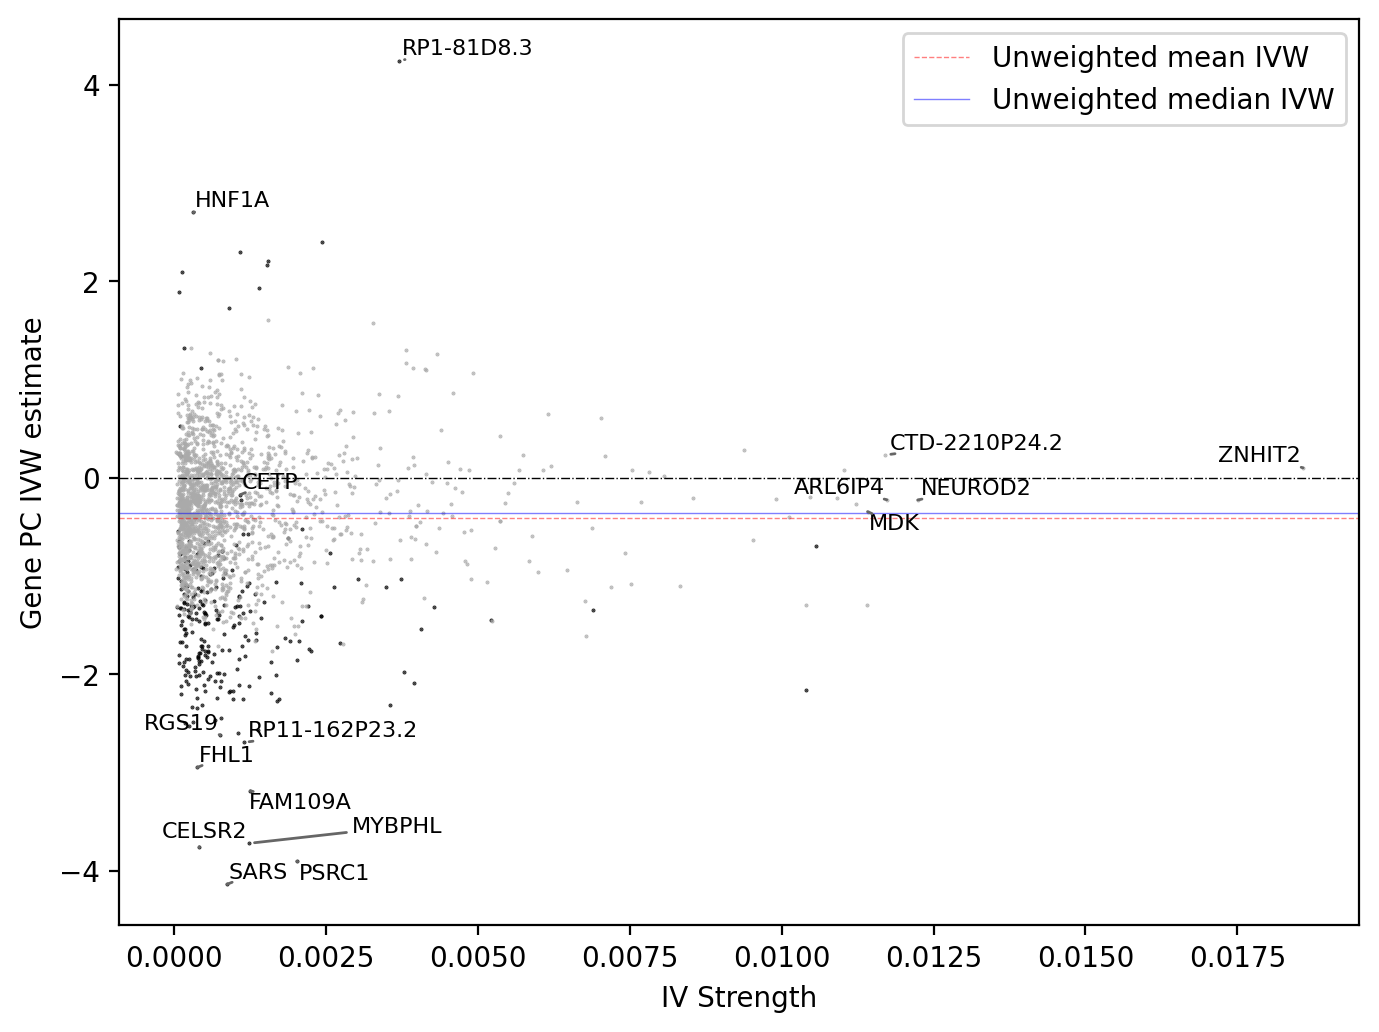

In [32]:
fig = plt.figure(figsize=(8, 6))
for sig, color in [(True, 'black'), (False, '#aaaaaa')]:
    if sig:
        pred = lambda o: o["wald_p"] <= 0.01
    else:
        pred = lambda o: o["wald_p"] > 0.01
    
    plt.scatter(
        # Instrument strength.
        [o["iv_strength"] for o in mr_results if pred(o)],
        
        # MR estimate
        [o["ivw_beta"] for o in mr_results if pred(o)],
        
        s=0.2,
        color=color,
        alpha=0.8
    )

texts = []
for o in points_to_label:
    # Get gene name.
    ensembl_id = o["gene"]
    req = requests.get(f"https://exphewas.ca/v1/api/gene/ensembl/{ensembl_id}")
    res = req.json()
    gene_name = res.get("name", ensembl_id)
    
    text = plt.annotate(gene_name, (o["iv_strength"], o["ivw_beta"]),
                        fontsize=8)
    
    texts.append(text)
    
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#666666'))

plt.axhline(y=0, linestyle="-.", linewidth=0.5, color="black")
plt.axhline(y=ivw_mean, linestyle="--", linewidth=0.5, color="red",
            label="Unweighted mean IVW", alpha=0.5)

plt.axhline(y=ivw_median, linestyle="-", linewidth=0.5, color="blue",
            label="Unweighted median IVW", alpha=0.5)

plt.legend()

plt.xlabel("IV Strength")
plt.ylabel("Gene PC IVW estimate")
plt.savefig("demo-cisMR_HDL-c_CAD.svg")